<a href="https://colab.research.google.com/github/rodrigosimass/mnist_FFNN_CNN/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section
Set up


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import KFold
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

In [5]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True)
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])
mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
def isBest(result, results):
  if(len(results)==0):
    return True
  if(result>max(results)):
    return True
  return False

Manual separation into train and validation:

# Baseline
No hidden 

In [0]:
mnist_baseline_model = tf.keras.Sequential(name='mnist_baseline')
mnist_baseline_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_baseline_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_baseline_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_baseline_model.summary()

Model: "mnist_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_baseline_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_baseline_model_train = mnist_baseline_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.6875 - accuracy: 0.5556
Epoch 00001: val_accuracy improved from -inf to 0.75017, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 5ms/step - loss: 1.6875 - accuracy: 0.5556 - val_loss: 1.2538 - val_accuracy: 0.7502
Epoch 2/10000
176/188 [===========================>..] - ETA: 0s - loss: 1.0729 - accuracy: 0.7803
Epoch 00002: val_accuracy improved from 0.75017 to 0.80417, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 1.0635 - accuracy: 0.7819 - val_loss: 0.9255 - val_accuracy: 0.8042
Epoch 3/10000
177/188 [===========================>..] - ETA: 0s - loss: 0.8461 - accuracy: 0.8170
Epoch 00003: val_accuracy improved from 0.80417 to 0.82792, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.8420 - accuracy: 0.8181 - val_loss: 0.7782 - val_accuracy: 0.8279
Epoch 4/10000
18

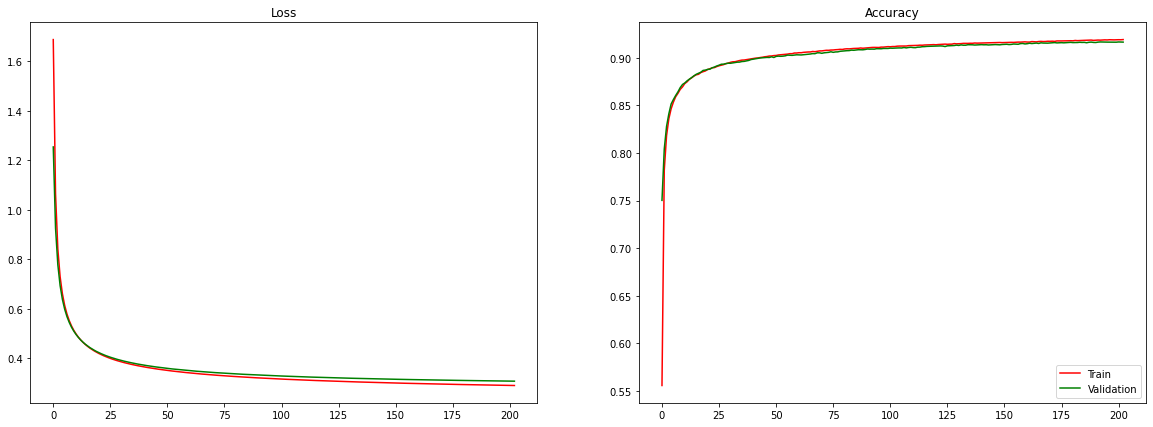

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_baseline_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_baseline_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_baseline_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_baseline_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

test the baseline

#Feed-Forward Neural Networks

test several models with different number of layers and neurons

cross validation is used and the best fold is selected in order to assess performance

---



In [13]:
num_hidden_layers = [1,2]
num_hidden_neurons = [50,100]
num_folds = 5; #cross validation
eps = 10000 #epochs

for layers in num_hidden_layers:
    print("\n\nhidden_layers=",layers)
    for num_neur in num_hidden_neurons:
        kf = KFold(n_splits=num_folds)
        results = []
        i = 1
        print("    num_neurons:",num_neur)
        for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
            #SPLIT THE DATA
            train_x = mnist_train_x[train_idx]
            train_y = mnist_train_y[train_idx]
            val_x = mnist_train_x[val_idx]
            val_y = mnist_train_y[val_idx]
            val_set = (val_x, val_y)

            #BUILD THE NN
            mlp = tf.keras.Sequential(name='MLP-1HU')
            mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
            mlp.add(tf.keras.layers.Flatten(name='flatten'))
            for i in range (layers):
                nm = "HU" + str(i)
                mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name=nm))
            mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

            mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

            #DEFINE CALL BACKS
            earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
            checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
            checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

            #TRAIN
            mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

            #ASSESS PERFORMANCE
            mlp.load_weights('multi_layer_2.h5')
            if(isBest(checkpoint_valid.best,results)):
                best_val = checkpoint_valid.best
                best_train = checkpoint_train.best
            results.append(checkpoint_valid.best);
            
        print(results)
        print("        val:",best_val," trn:",best_train)



hidden_layers= 3
    num_neurons: 50


KeyboardInterrupt: ignored

train one model

In [48]:
num_hidden_layers = 2
num_neur = 100
num_folds = 5; #cross validation
eps = 10000 #epochs

kf = KFold(n_splits=num_folds)
results = []
i = 1
for train_idx, val_idx in kf.split(mnist_train_x, mnist_train_y):
    print("fold",i,"/",num_folds)
    i+=1
    #SPLIT THE DATA
    train_x = mnist_train_x[train_idx]
    train_y = mnist_train_y[train_idx]
    val_x = mnist_train_x[val_idx]
    val_y = mnist_train_y[val_idx]
    val_set = (val_x, val_y)

    #BUILD THE NN
    mlp = tf.keras.Sequential(name='MLP-1HU')
    mlp.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
    mlp.add(tf.keras.layers.Flatten(name='flatten'))
    for j in range (num_hidden_layers):
        nm = "HU" + str(j)
        mlp.add(tf.keras.layers.Dense(num_neur, activation='tanh', name=nm))
    mlp.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))

    mlp.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    #DEFINE CALL BACKS
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
    checkpoint_train = tf.keras.callbacks.ModelCheckpoint('MLP-1HU.h5', monitor='accuracy', verbose=0, save_best_only=True)
    checkpoint_valid = tf.keras.callbacks.ModelCheckpoint('multi_layer_2.h5', monitor='val_accuracy', verbose=0, save_best_only=True)

    #TRAIN
    mlp_train = mlp.fit(mnist_train_x, mnist_train_y, validation_data= val_set, callbacks=[earlystop,checkpoint_train,checkpoint_valid], epochs=eps, batch_size=256, verbose=0)

    #ASSESS PERFORMANCE
    mlp.load_weights('multi_layer_2.h5')
    if(isBest(checkpoint_valid.best,results)): #TODO verificar se esta a usar a melhor validation
        #SAVE MODEL OF BEST FOLD
        mlp.save_weights('best_MLP.h5')
        best_model = mlp_train
        best_val = checkpoint_valid.best
        best_train = checkpoint_train.best
    results.append(checkpoint_valid.best);

fold 1 / 5
fold 2 / 5
fold 3 / 5
fold 4 / 5
fold 5 / 5


plot the train:

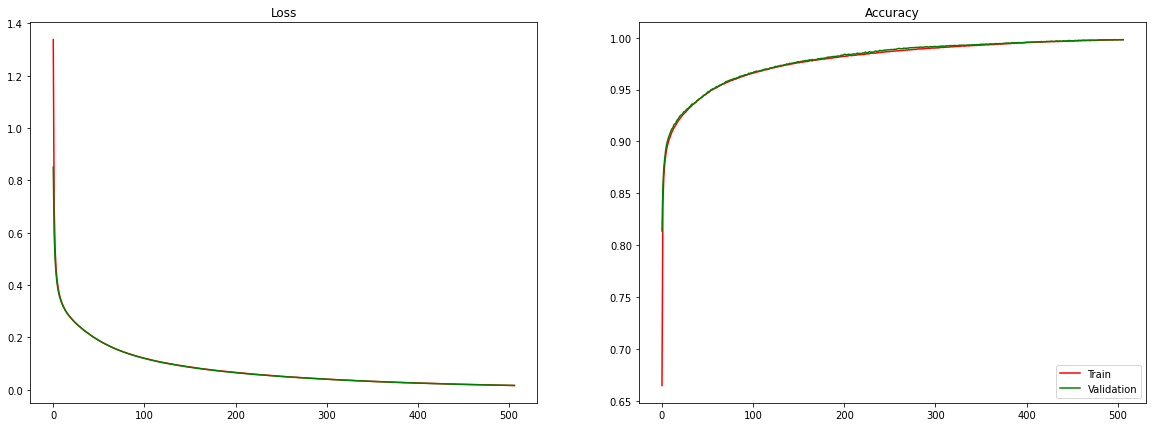

In [49]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(best_model.history['loss'], '-r', label='Train')
loss_ax.plot(best_model.history['val_loss'], '-g', label='Validation')
acc_ax.set_title('Accuracy')
acc_ax.plot(best_model.history['accuracy'], '-r', label='Train')
acc_ax.plot(best_model.history['val_accuracy'], '-g', label='Validation')
plt.legend(loc=4)
plt.show()

and finally... use the test set

In [50]:
#stats of all the folds
print("All folds:")
print(results)
#satts of best fold
print("Best fold:")
print("valid acc:",best_val)
print("train acc:",best_train)
#and finally we test
mlp.load_weights('best_MLP.h5')
loss, acc = mlp.evaluate(mnist_test_x, mnist_test_y)
print('\n---------------------------------------\n| TEST ACCURACY =  {}  |\n---------------------------------------\n'.format(acc))

All folds:
[0.9929999709129333, 0.9897500276565552, 0.996999979019165, 0.9950000047683716, 0.9981666803359985]
Best fold:
valid acc: 0.9981666803359985
train acc: 0.9980666637420654
313/313 [==============================] - 1s 2ms/step - loss: 0.0727 - accuracy: 0.9778

---------------------------------------
| TEST ACCURACY =  0.9778000116348267  |
---------------------------------------



# CNN

In [0]:
tf.random.set_seed(1) #to ensure same data split for all models

conv_model = tf.keras.Sequential(name='mnist_cnn')
conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
conv_model.add(tf.keras.layers.Flatten(name='flatten'))
conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

conv_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
conv_checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_model_train = conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2,
                                        callbacks=[conv_earlystop,conv_checkpoint], 
                                        epochs=10000, batch_size=256)


" tf.random.set_seed(1) #to ensure same data split for all models\n\nconv_model = tf.keras.Sequential(name='mnist_cnn')\nconv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))\nconv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))\nconv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))\nconv_model.add(tf.keras.layers.Flatten(name='flatten'))\nconv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))\nconv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])\n\nconv_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)\nconv_checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)\n\nmnist_conv_model_train = conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2,\n        

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show() 

" fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))\n\nloss_ax.set_title('Loss')\nloss_ax.plot(mnist_conv_model_train.history['loss'], '-r', label='Train')\nloss_ax.plot(mnist_conv_model_train.history['val_loss'], '-g', label='Validation')\n\nacc_ax.set_title('Accuracy')\nacc_ax.plot(mnist_conv_model_train.history['accuracy'], '-r', label='Train')\nacc_ax.plot(mnist_conv_model_train.history['val_accuracy'], '-g', label='Validation')\n\nplt.legend(loc=4)\nplt.show() "